# Pendulum Network

Here I'll investigate the capabilities of NNs to learn phase transitions when trained in only on phase. Concretely, I'll train a network to solve the simple pendulum ODE on the periodic regime, and analyze how much data it needs to generalize to the non-periodic regime.

In [313]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import math

### Basic setup

In [314]:
def RK_method(F, t0, x0, h, n_steps, a, b, c):
    dim = len(x0)
    l = len(b)
    t = np.arange(t0, t0 + h*n_steps, h)
    x = np.zeros((n_steps, dim))
    x[0] = x0
    k = np.zeros((l, dim))

    for n in range(1, n_steps):
        k[0] = F(t[n-1], x[n-1])
        for i in range(1, l):
            t_i = t[n-1] + h * c[i]
            x_i = x[n-1] + h * np.dot(a[i-1][:i], k[:i])
            k[i] = F(t_i, x_i)
        x[n] = x[n-1] + h * np.dot(b, k)

    return t, x

# Classical (4-stage) Runge-Kutta
def RK4(F, t0, x0, h, n_steps):
    a = np.array(
        [[0.5, 0, 0],
         [0, 0.5, 0],
         [0, 0, 1]]
    )
    b = np.array([1/6, 2/6, 2/6, 1/6])
    c = np.array([0, 0.5, 0.5, 1])
    return RK_method(F, t0, x0, h, n_steps, a, b, c)

In [315]:
def pendulum(t, X):
	x, v = X
	Dx = v
	Dv = -np.sin(x)
	return np.array([Dx, Dv])

THE PERIOD DOES NOT DEPEND ON THE INITIAL VELOCITY, don't you remember this from mechanics?

2
64


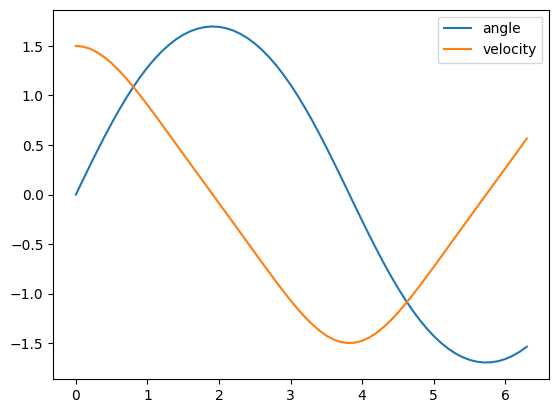

In [463]:
eps = 1e-4
t0 = 0
x0 = np.array([0, 1.5])
h = 0.1
print(2)
n_steps = 64
print(n_steps)
t, X = RK4(pendulum, t0, x0, h, n_steps)
plt.plot(t, X[:, 0], label="angle")
plt.plot(t, X[:, 1], label="velocity")
plt.legend()
plt.show()

Plot vector field

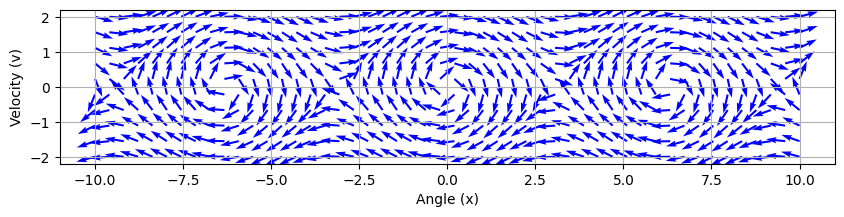

In [317]:
x = np.linspace(-10, 10, 50)
v = np.linspace(-2, 2, 10)
X, V = np.meshgrid(x, v)
dX = V / np.sqrt(V**2 + np.sin(X)**2)
dV = -np.sin(X) / np.sqrt(V**2 + np.sin(X)**2)

plt.figure(figsize=(10, 2))
plt.quiver(X, V, dX, dV, color='b')
plt.xlabel("Angle (x)")
plt.ylabel("Velocity (v)")
plt.grid(True)
plt.show()

### Training

Both empirically and theoretically, if we start at 'x = 0' the threshold between periodic and aperiodic solution is '|v| = 2'. So let's train the network with datapoints collected from initial conditions with '|v| < 2'. They can all start at x = 0, since all that matters for the network is the tuples (x, x + dx).

Here's how we'll structure the data: (x, y) will be many random pairs of the form ((x,v), (x+dx,v+dv)). I'll generate them by sampling many v's from Unif(0, 1.8) and computing many solutions with initial condition [0, v].

In [505]:
N_VELS = 20480
H = 0.1
N_STEPS = 64
THRESHOLD = 10

Note that I'm only generating non-negative v's, but that's not a problem since v goes through the entire range of values [-THRES, THRES] in the solution, so we'll have data for the negative values too.

In [506]:
vels = 2*THRESHOLD * (np.random.rand((N_VELS)) - 0.5)
sols = [torch.from_numpy(RK4(pendulum, 0, np.array([0, vels[n]]), H, N_STEPS)[1]).to(torch.float32) for n in range(N_VELS)]

In [507]:
print(min(vels), max(vels))
print(len(sols))

-9.999165872195848 9.9994673381815
20480


In [508]:
# List of tuples of type (X[n], X[n+1])
in_n_out = []
for v in range(N_VELS): # Iterate through solutions of varying 'v'
	for n in range(N_STEPS-1): # Iterate within solution
		# Create tuple
		data = (sols[v][n], sols[v][n+1])
		in_n_out.append(data)

In [509]:
# We need to create out own Dataset class
class PendulumDataset(Dataset):
	def __init__(self, tuples_list):
		self.data = tuples_list

	def __len__(self):
		return len(self.data)
	
	def __getitem__(self, idx):
		input, output = self.data[idx]
		return input, output

In [510]:
# Create dataset and dataloader
dataset = PendulumDataset(in_n_out)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [519]:
# Create network class
layer_dim = 256

class PendulumNetwork(nn.Module):
	def __init__(self):
		super().__init__()
		self.network = nn.Sequential(
			nn.Linear(2, layer_dim),
			nn.ReLU(),
			nn.Linear(layer_dim, layer_dim),
			nn.ReLU(),
			nn.Linear(layer_dim, layer_dim),
			nn.ReLU(),
			nn.Linear(layer_dim, 2)
		)

	def forward(self, x):
		logits = self.network(x)
		return x + logits

In [520]:
# Hyperparameters
lr = 3e-4
wd=3e-4
n_epochs = 2

In [521]:
# Define network, loss function and optimizer
model = PendulumNetwork()
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

In [522]:
def train_loop(model, loss_fn, optimizer, dataloader, n_epochs):
	for epoch in range(n_epochs):
		print(f"epoch {epoch+1}------------")
		for i, batch in enumerate(dataloader):
			# Get data and compute prediction
			x, y = batch
			pred = model(x)

			# Compute loss and optimize
			loss = loss_fn(y, pred)
			loss.backward()
			optimizer.step()
			optimizer.zero_grad()

			# Print loss
			if i % 1000 == 0:
				print(loss.item())

In [523]:
train_loop(model, loss_fn, optimizer, dataloader, n_epochs)

epoch 1------------
0.7017198801040649
0.001938401721417904
0.0014858667273074389
0.0015091467648744583
0.0020002371165901423
0.0015123505145311356
0.0017001500818878412
0.0007560880621895194
0.0011160657741129398
0.0011816485784947872
0.001103924005292356
0.0011532179778441787
0.0008756113238632679
0.0011652697576209903
0.0010647388407960534
0.0010410480899736285
0.0009394186781719327
0.0009010235662572086
0.0004080036305822432
0.0012835050001740456
0.0009883882012218237
epoch 2------------
0.000920736463740468
0.0009415210224688053
0.00101270095910877
0.0004995740600861609
0.0009054379188455641
0.0007743823225609958
0.0005191446980461478
0.000821717781946063
0.0008256472065113485
0.000564107671380043
0.0007743813912384212
0.0005348534905351698
0.0005112394574098289
0.0005871145986020565
0.0009062901372089982
0.0005035755457356572
0.000694935442879796
0.0005814731703139842
0.0005478548118844628
0.0007345991907641292
0.0005370035069063306


### Testing

You know what, I think if I train the network with high enough values of 'x' (also high negative values), it'll learn to be periodic because of weight decay. I should also investigate how well it generalizes there.

In [524]:
# First let's write a function that plots the solution for n_steps given a specific initial condition
def network_solver(model, x0, n_steps):
	x = torch.zeros((n_steps, 2), dtype=torch.float32)
	x[0] = torch.from_numpy(x0)
	for n in range(1, n_steps):
		with torch.no_grad():
			x[n] = model(x[n-1])
	
	return x

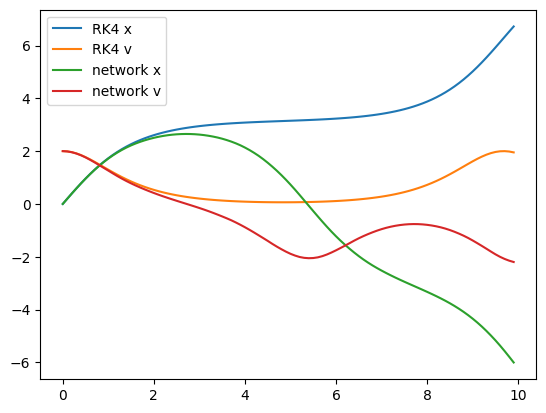

In [531]:
eps = 1e-4
t0 = 0
x0 = np.array([0, 2.001])
n_steps = 100
t, X = RK4(pendulum, t0, x0, H, n_steps)
X_network = network_solver(model, x0, n_steps)

plt.plot(t, X[:, 0], label="RK4 x")
plt.plot(t, X[:, 1], label="RK4 v")
plt.plot(t, X_network[:, 0], label="network x")
plt.plot(t, X_network[:, 1], label="network v")
plt.legend()
plt.show()

It didn't generalize at all OOD. I guess that was to be expected, because I only trained it with x values all within a 2pi length interval.

HYPOTHESIS: If I train it on larger intervals, with lengths containing multiple 2pi-sized intervals, then it'll learn to be periodic and generalize very OOD.